In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch.utils.data import Dataset
from random import randint
import torchvision.datasets as dset
import torchvision.transforms as transforms


In [2]:
# Funzioni utili
pilToTensor = torchvision.transforms.ToTensor()
tensorToPil = torchvision.transforms.ToPILImage()
scala = torchvision.transforms.Resize((190,190))

In [3]:
!conda install -y gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.2.1              |       hd590300_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  filelock    

# **Generator Neural Network**

In [4]:
def generatorLabel(label,batch):
    if label=='human' or label==0:
        y = torch.Tensor()
        for i in range(batch):
            y = torch.cat((y,torch.Tensor([1,0]).reshape([1,2])))
    elif label=='anime' or label==1:
        y = torch.Tensor()
        for i in range(batch):
            y = torch.cat((y,torch.Tensor([0,1]).reshape([1,2])))
    else:
        raise Exception("Incorrect Label")
    return y

In [5]:
### Creiamo il Generatore

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linearLayer = nn.Sequential(
            nn.Linear(102, 4*4*1024),
            nn.LeakyReLU(0.2)
        )

        self.dcganLayers = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 3, 5, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        input = self.linearLayer(input)
        input = input.view(-1, 1024, 4, 4)
        output = self.dcganLayers(input)
        return output

# **Discriminator Neural Network**

In [6]:
def discriminatorLabel(label,batch):
    if label=='human' or label==0:
        y = torch.Tensor()
        for i in range(batch):
            y = torch.cat((y,torch.cat((torch.ones(1,1,32,32),torch.zeros(1,1,32,32)),1)))
    elif label=='anime' or label==1:
        y = torch.Tensor()
        for i in range(batch):
            y = torch.cat((y,torch.cat((torch.zeros(1,1,32,32),torch.ones(1,1,32,32)),1)))
    else:
        raise Exception("Incorrect Label")
    return y
        

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(
            nn.Conv2d(3,64,4,stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.net2 = nn.Sequential(
            nn.Conv2d(66,128,4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128,256,4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256,512,4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Conv2d(512,1,4),
            nn.Sigmoid()

        )

    def forward(self, input, ny):
        output = self.net1(input)
        output = torch.cat((output,ny),1)
        return self.net2(output)

# **Encoders**

In [8]:
class EncoderZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.netZConv = nn.Sequential(
            nn.Conv2d(3,32,5,stride=2),#,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,64,5,stride=2),#nn.Conv2d(128,256,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,128,5,stride=2),#nn.Conv2d(256,512,4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,256,5,stride=2),#nn.Conv2d(256,512,4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.netZFully = nn.Sequential(
            nn.Linear(256,4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),

            nn.Linear(4096,100)
        )

    def forward(self, input):
        output = self.netZConv(input)
        output = output.reshape(input.size()[0],256)
        output = self.netZFully(output)
        return output

In [9]:
class EncoderY(nn.Module):
    def __init__(self):
        super().__init__()
        self.netZConv = nn.Sequential(
            nn.Conv2d(3,32,5,stride=2),#,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,64,5,stride=2),#nn.Conv2d(128,256,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,128,5,stride=2),#nn.Conv2d(256,512,4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,256,5,stride=2),#nn.Conv2d(256,512,4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.netZFully = nn.Sequential(
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,2)
        )

    def forward(self, input):
        output = self.netZConv(input)
        output = output.reshape(input.size()[0],256)
        output = self.netZFully(output)
        return output

# **Dataset**

In [11]:
#Scarichiamo ildataset con le immagini degli umani
!gdown https://drive.google.com/file/d/1-RxNB7f1dbZ-YQyol6aMZmIQN3e_hY7n/view?usp=drive_link --fuzzy
humanImagData = torch.load('/kaggle/working/humanImagData.pt')
!rm -rf /kaggle/working/humanImagData.pt

Downloading...
From (original): https://drive.google.com/uc?id=1-RxNB7f1dbZ-YQyol6aMZmIQN3e_hY7n
From (redirected): https://drive.google.com/uc?id=1-RxNB7f1dbZ-YQyol6aMZmIQN3e_hY7n&confirm=t&uuid=591f4142-74ed-4759-ba28-b683acbe43fa
To: /kaggle/working/humanImagData.pt
100%|████████████████████████████████████████| 492M/492M [00:06<00:00, 70.6MB/s]


In [17]:
class HumanDataset(Dataset):
    def __init__(self, imageTensor):
        self.imageTensor = imageTensor

    def __len__(self):
        return len(self.imageTensor)

    def __getitem__(self, idx):
        image = self.imageTensor[idx]
        ny = discriminatorLabel(0,1)[0]

        return image, ny


humanDataset = HumanDataset(humanImagData)


In [18]:
animeDataset = dset.ImageFolder(root='/kaggle/input/animefacedataset',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# **Inizializzazione Reti**

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss = nn.BCELoss()
lossEncoder = nn.MSELoss()


netDisc = Discriminator().to(device)
optDisc = torch.optim.Adam(netDisc.parameters(),lr=0.0002, betas=(0.5, 0.999), eps=1e-08)

netGen = Generator().to(device)
optGen = torch.optim.Adam(netGen.parameters(),lr=0.0002, betas=(0.5, 0.999), eps=1e-08)


netEncZ = EncoderZ().to(device)
optEncZ = torch.optim.Adam(netEncZ.parameters(),lr=0.0001, betas=(0.1, 0.999), eps=1e-08)

netEncY = EncoderY().to(device)
optEncY = torch.optim.Adam(netEncY.parameters(),lr=0.0001, betas=(0.1, 0.999), eps=1e-08)

batchSize = 32
animeDataloader = torch.utils.data.DataLoader(animeDataset, batch_size=batchSize,shuffle=True)
humanDataloader = torch.utils.data.DataLoader(humanDataset, batch_size=batchSize,shuffle=True)
epoche = 25

print(device)

cpu


# **Training Generator Discriminator**

In [50]:
for epoca in range(epoche):

    print('epoca numero '+str(epoca))
    iteratoreAnime = iter(animeDataloader)
    iteratoreHuman = iter(humanDataloader)
    #plt.imshow(tensorToPil(netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),torch.Tensor([0,1]))).reshape([1,102,1,1]))[0]))
    for j in range(282):
        imageAnime, nyAnime= next(iteratoreAnime)
        nyAnime = discriminatorLabel(1,imageAnime.size()[0])
        imageAnime, nyAnime = imageAnime.to(device), nyAnime.to(device)
        
        imageHuman, nyHuman = next(iteratoreHuman)
        imageHuman, nyHuman = imageHuman.to(device), nyHuman.to(device)
        
        
        netDisc.zero_grad()
        errorDiscReal = 0
        #Immagini Reali
        
        
        ###Immagini Anime 
        outputRealAnime = netDisc(imageAnime,nyAnime)
        dimensioneAnime = outputRealAnime.size()[0]
        realLabel = torch.ones(dimensioneAnime).reshape([dimensioneAnime,1])-torch.mul(torch.rand(dimensioneAnime).reshape([dimensioneAnime,1]),0.2)
        errorDiscReal += loss(outputRealAnime.reshape([dimensioneAnime,1]),realLabel.to(device))
        
        ###Immagini Umani
        outputRealUmani = netDisc(imageHuman,nyHuman)
        dimensioneUmani = outputRealUmani.size()[0]
        realLabel = torch.ones(dimensioneUmani).reshape([dimensioneUmani,1])-torch.mul(torch.rand(dimensioneUmani).reshape([dimensioneUmani,1]),0.2)
        errorDiscReal += loss(outputRealUmani.reshape([dimensioneUmani,1]),realLabel.to(device))
        
        #Immagini Generate
        errorDiscFalso = 0
        
        ###Immagini Anime
        rumoreImageAnime = torch.Tensor()
        yRumoreAnime = torch.Tensor()
        for i in range(dimensioneAnime):
            rumoreImageAnime = torch.cat((rumoreImageAnime,(torch.normal(torch.zeros(100),torch.ones(100)).reshape([1,100]))))
            yRumoreAnime = torch.cat((yRumoreAnime,generatorLabel(1,1)))
        rumoreImputAnime = torch.cat((rumoreImageAnime,yRumoreAnime),1).to(device)
        ###Creiamo le immagini Generate
        imageGenerateAnime = netGen(rumoreImputAnime)
        ###Calcoliamo l'output Generato della rete discriminatoria
        outputGenAnime = netDisc(imageGenerateAnime,nyAnime)
        ###Errore Generato
        fakeLabelsAnime = torch.mul(torch.rand(dimensioneAnime).reshape([dimensioneAnime,1]),0.2)+torch.zeros(dimensioneAnime).reshape([dimensioneAnime,1])
        errorDiscFalso += loss(outputGenAnime.reshape([dimensioneAnime,1]),fakeLabelsAnime.to(device))
        
        ###Immagini Umani
        rumoreImageUmani = torch.Tensor()
        yRumoreUmani = torch.Tensor()
        for i in range(dimensioneUmani):
            rumoreImageUmani = torch.cat((rumoreImageUmani,(torch.normal(torch.zeros(100),torch.ones(100)).reshape([1,100]))))
            yRumoreUmani = torch.cat((yRumoreUmani,generatorLabel(0,1)))
        rumoreImputUmani = torch.cat((rumoreImageUmani,yRumoreUmani),1).to(device)
        ###Creiamo le immagini Generate
        imageGenerateUmani = netGen(rumoreImputUmani)
        ###Calcoliamo l'output Generato della rete discriminatoria
        outputGenUmani = netDisc(imageGenerateUmani,nyHuman)
        ###Errore Generato
        fakeLabelsUmani = torch.mul(torch.rand(dimensioneUmani).reshape([dimensioneUmani,1]),0.2)+torch.zeros(dimensioneUmani).reshape([dimensioneUmani,1])
        errorDiscFalso += loss(outputGenUmani.reshape([dimensioneUmani,1]),fakeLabelsUmani.to(device))
        
        ##Calcoliamo le derivate
        #errorDiscReal.backward()
        #errorDiscFalso.backward()
        error = errorDiscReal+errorDiscFalso
        ##Ottimiziamo la rete
        if error>0.25:
            error.backward()
            optDisc.step()


        #Alleniamo la rete generatoria
        #errorGen = torch.Tensor([100])
        i = 0
        while(i<1):
            netGen.zero_grad()
            ##Creiamo Rumore Falso
            #rumoreImage = torch.Tensor()
            #yRumore = torch.Tensor()
            
            errorGen = 0
            
            #Immagini Anime 
            nyGeneAnime = torch.Tensor()
            rumoreImageGeneAnime = torch.Tensor()
            yRumoreGeneAnime = torch.Tensor()
            #batchSizeGenerato = 112
            for i in range(batchSize):
                rumoreImageGeneAnime = torch.cat((rumoreImageGeneAnime,(torch.normal(torch.zeros(100),torch.ones(100)).reshape([1,100]))))
                yRumoreGeneAnime = torch.cat((yRumoreGeneAnime,generatorLabel(1,1)))
                nyGeneAnime = torch.cat((nyGeneAnime,discriminatorLabel(1,1)))
            nyGeneAnime = nyGeneAnime.to(device)
            ##Generiamo delle Immagini
            rumoreGeneImputAnime = torch.cat((rumoreImageGeneAnime,yRumoreGeneAnime),1).to(device)
            imageGenerateAnime = netGen(rumoreGeneImputAnime)
            ##Diamolo in pasto al discriminatore
            outputGenAnime = netDisc(imageGenerateAnime,nyGeneAnime)
            ##Calcoliamo l'errore
            errorGen += loss(outputGenAnime.reshape([batchSize,1]),torch.ones([batchSize,1]).to(device))
            
            
            #Immagini Umani 
            nyGeneUmani = torch.Tensor()
            rumoreImageGeneUmani = torch.Tensor()
            yRumoreGeneUmani = torch.Tensor()
            #batchSizeGenerato = 112
            for i in range(batchSize):
                rumoreImageGeneUmani = torch.cat((rumoreImageGeneUmani,(torch.normal(torch.zeros(100),torch.ones(100)).reshape([1,100]))))
                yRumoreGeneUmani = torch.cat((yRumoreGeneUmani,generatorLabel(0,1)))
                nyGeneUmani = torch.cat((nyGeneUmani,discriminatorLabel(0,1)))
            nyGeneUmani = nyGeneUmani.to(device)
            ##Generiamo delle Immagini
            rumoreGeneImputUmani = torch.cat((rumoreImageGeneUmani,yRumoreGeneUmani),1).to(device)
            imageGenerateUmani = netGen(rumoreGeneImputUmani)
            ##Diamolo in pasto al discriminatore
            outputGenUmani = netDisc(imageGenerateUmani,nyGeneUmani)
            ##Calcoliamo l'errore
            errorGen += loss(outputGenUmani.reshape([batchSize,1]),torch.ones([batchSize,1]).to(device))
            
            
            errorGen.backward()
            optGen.step()
            #if i%50==0:
            #    print('iterazione numero : '+str(i)+'errore : '+str(errorGen))
            i = i+1
            
    
    torch.save(netGen.state_dict(), 'netGen2048'+str(epoca)+'.pt')
    torch.save(netDisc.state_dict(), 'netDisc2048'+str(epoca)+'.pt')
    print('epoca '+str(epoca)+' errore Disc = '+str(error)+' errore Gen = '+str(errorGen))

epoca numero 0
epoca 0 errore Disc = tensor(1.9153, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(4.2171, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 1
epoca 1 errore Disc = tensor(2.0370, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(3.7154, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 2
epoca 2 errore Disc = tensor(1.8714, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(5.0064, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 3
epoca 3 errore Disc = tensor(1.9960, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(2.5763, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 4
epoca 4 errore Disc = tensor(2.1826, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(5.2925, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 5
epoca 5 errore Disc = tensor(1.8646, device='cuda:0', grad_fn=<AddBackward0>) errore Gen = tensor(5.8153, device='cuda:0', grad_fn=<AddBackward0>)
epoca numero 6
epoca 6 error

KeyboardInterrupt: 

epoca numero 0


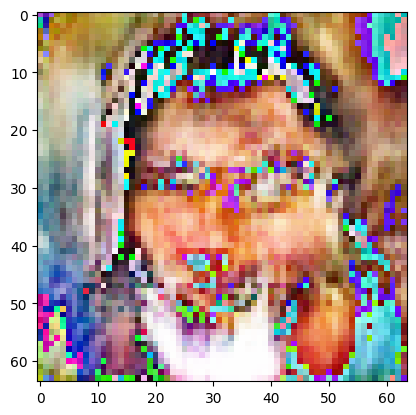

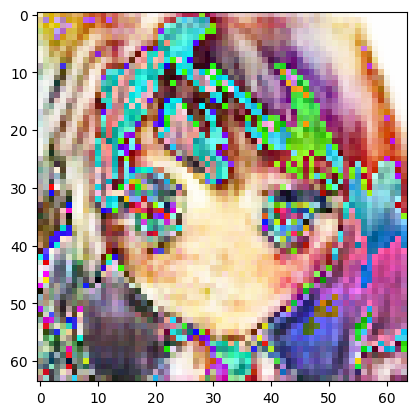

epoca numero 1


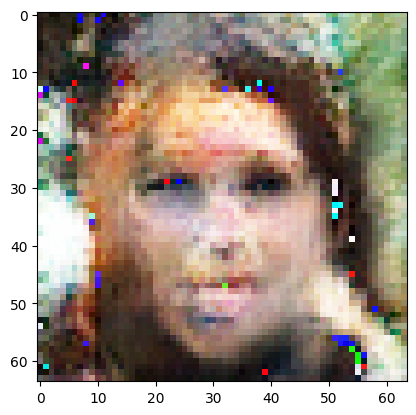

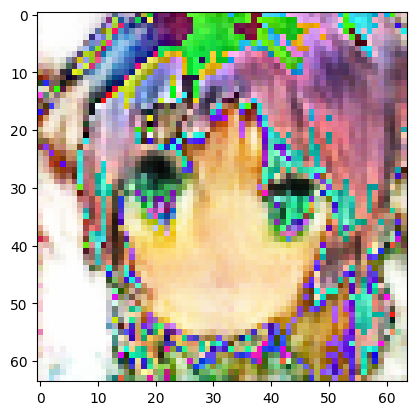

epoca numero 2


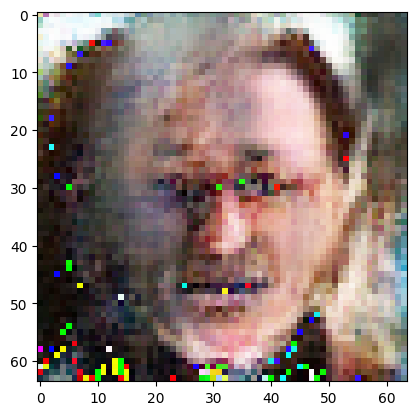

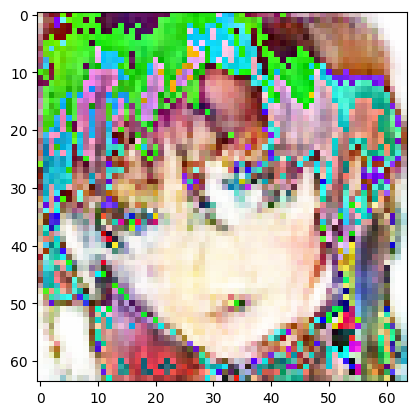

epoca numero 3


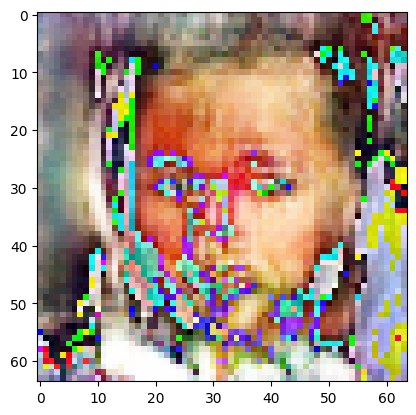

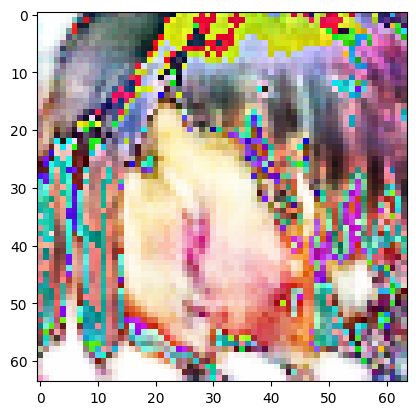

epoca numero 4


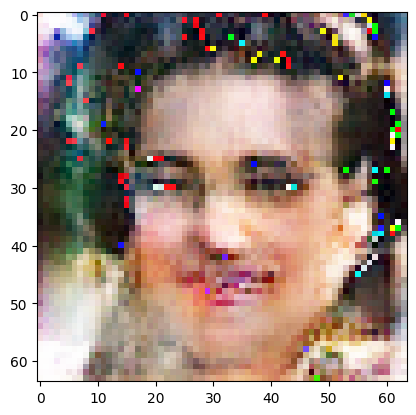

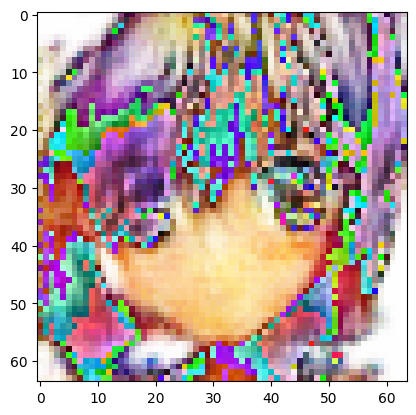

epoca numero 5


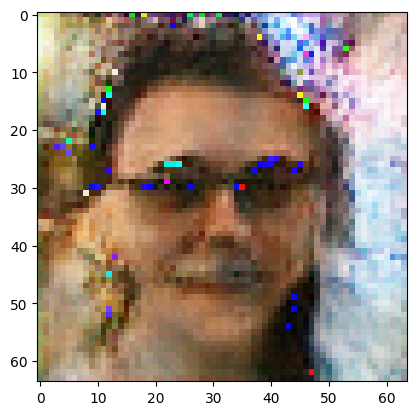

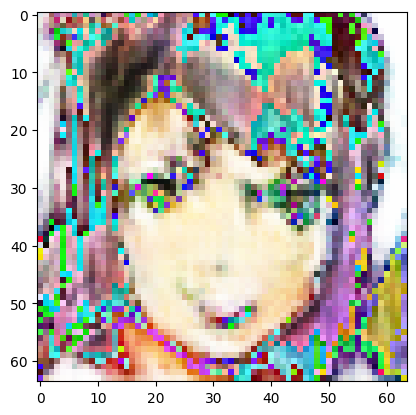

epoca numero 6


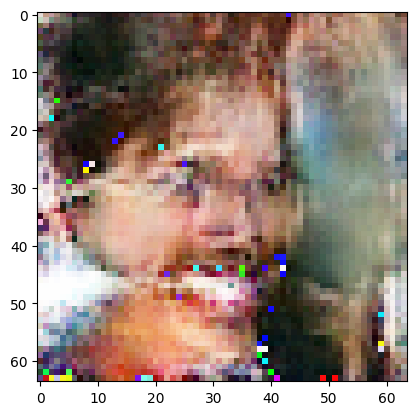

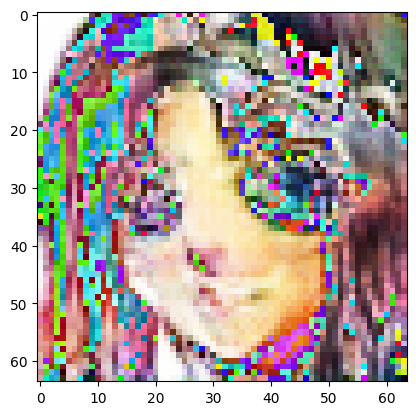

epoca numero 7


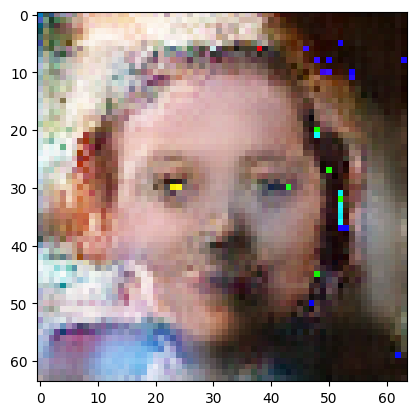

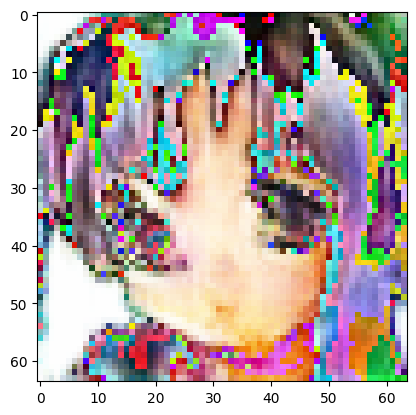

epoca numero 8


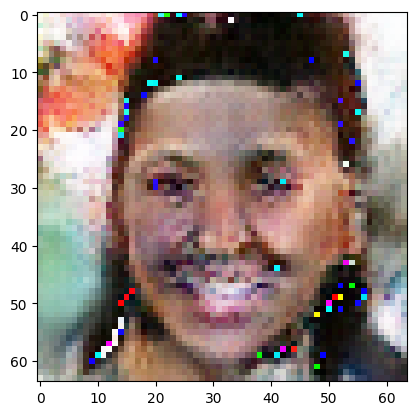

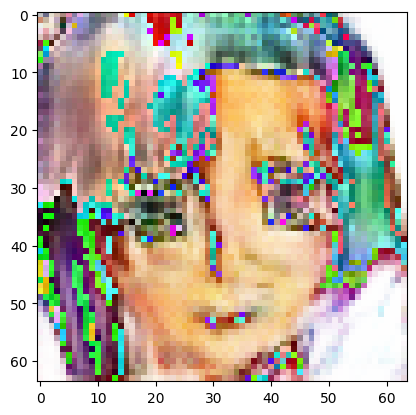

epoca numero 9


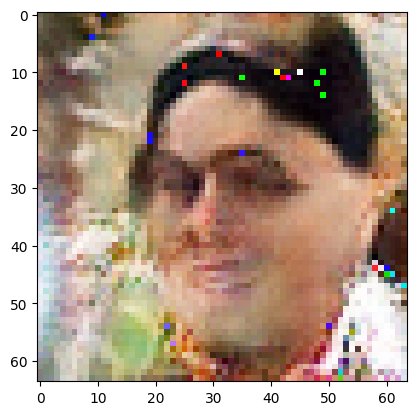

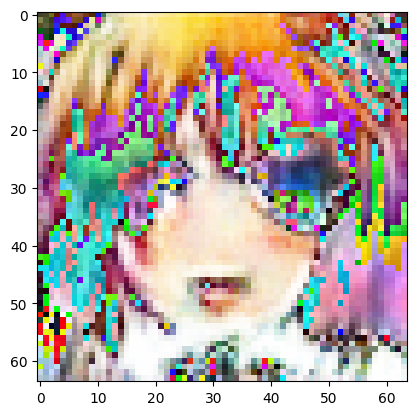

epoca numero 10


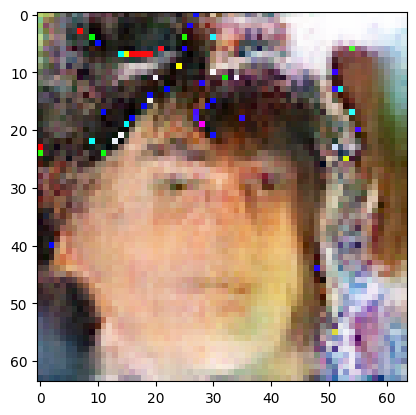

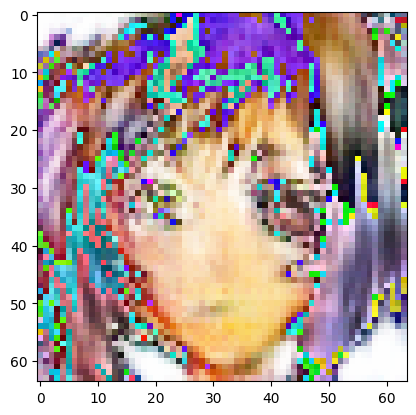

epoca numero 11


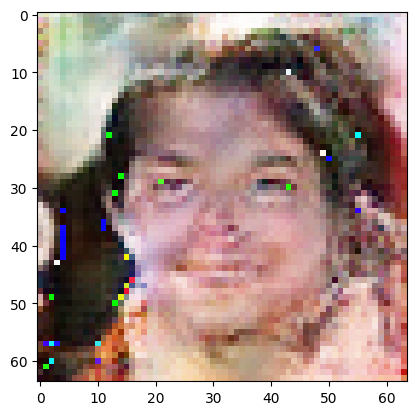

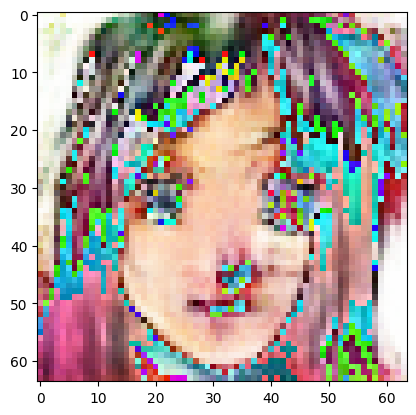

epoca numero 12


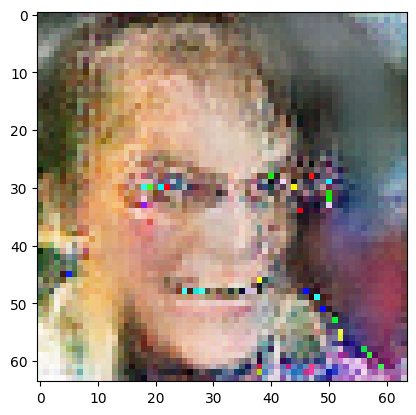

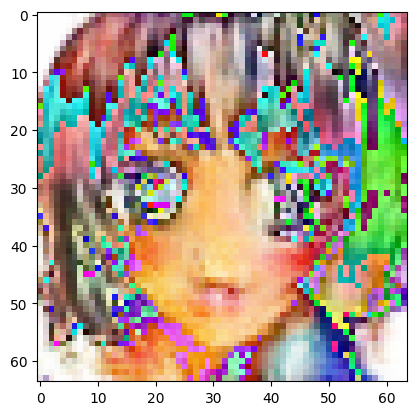

epoca numero 13


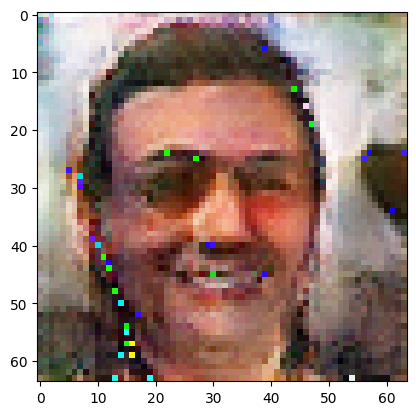

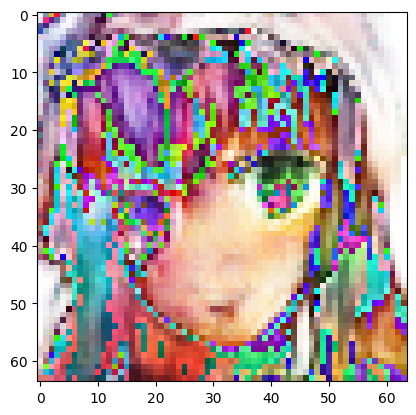

epoca numero 14


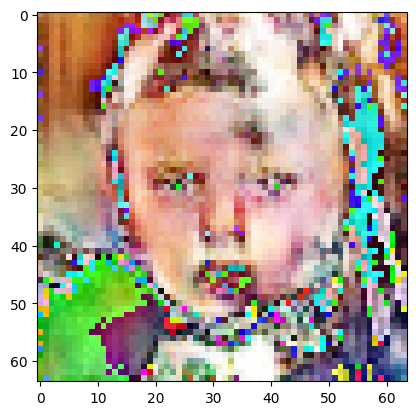

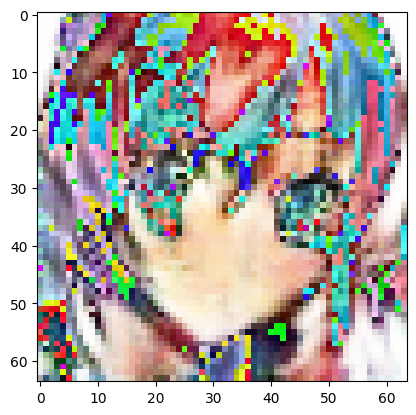

epoca numero 15


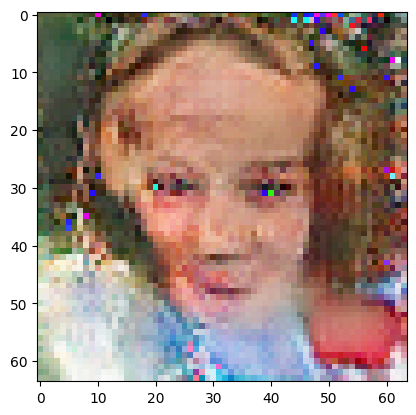

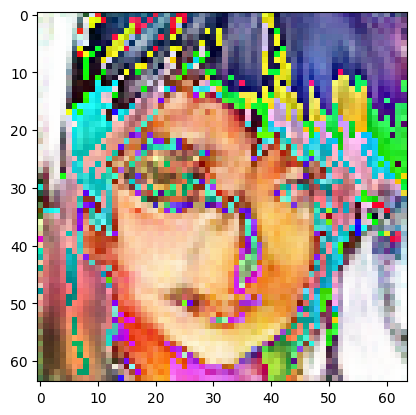

epoca numero 16


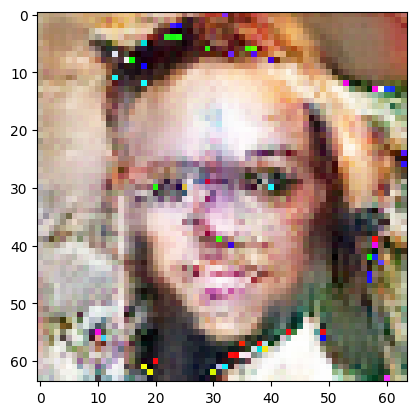

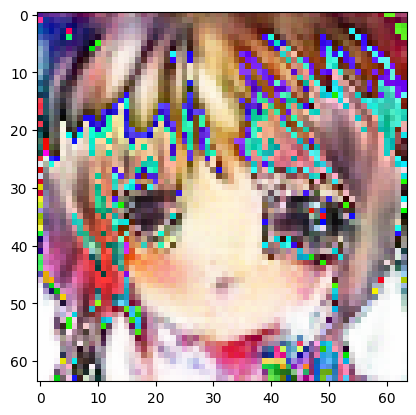

epoca numero 17


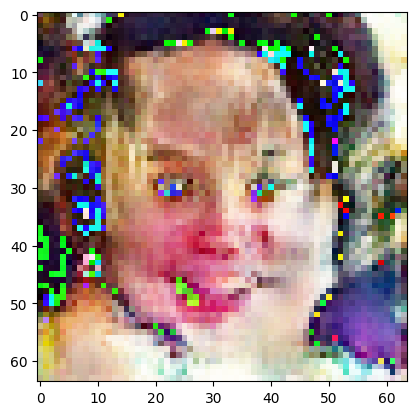

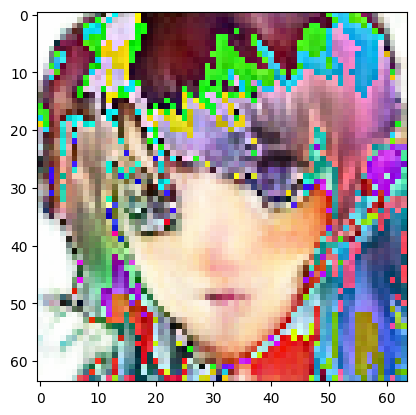

epoca numero 18


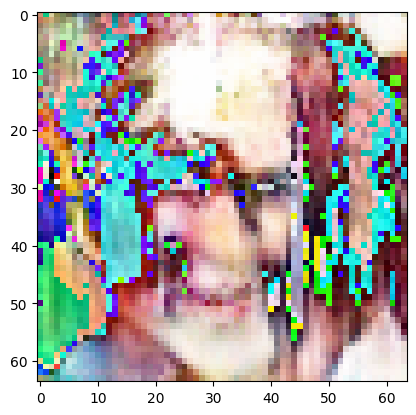

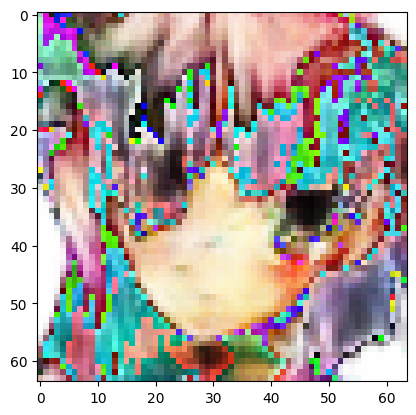

epoca numero 19


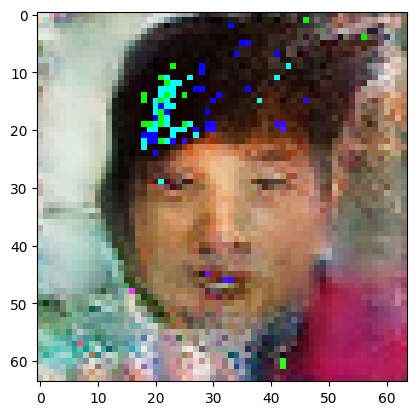

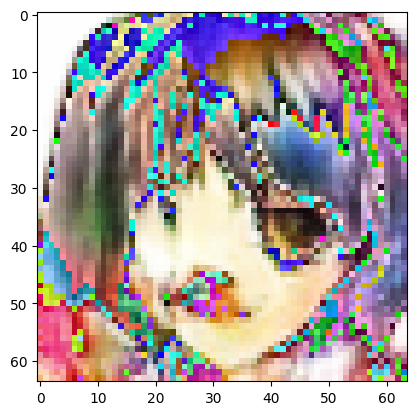

epoca numero 20


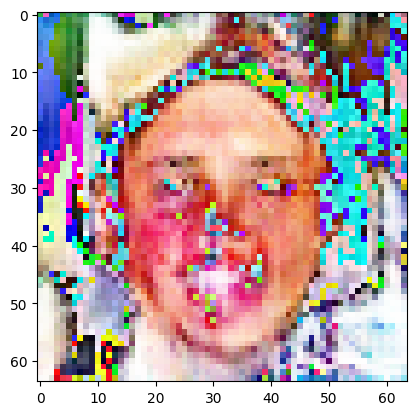

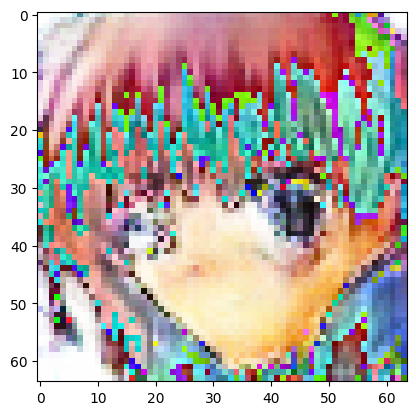

epoca numero 21


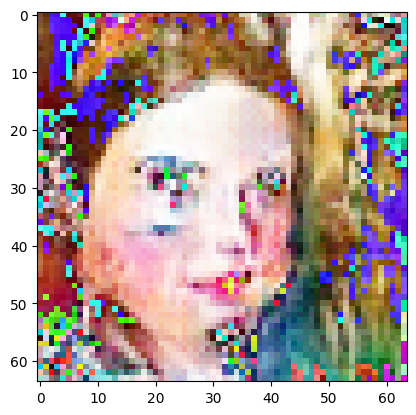

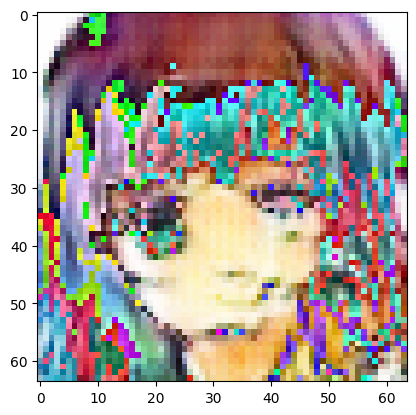

epoca numero 22


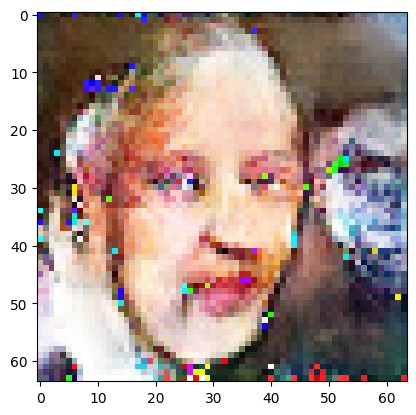

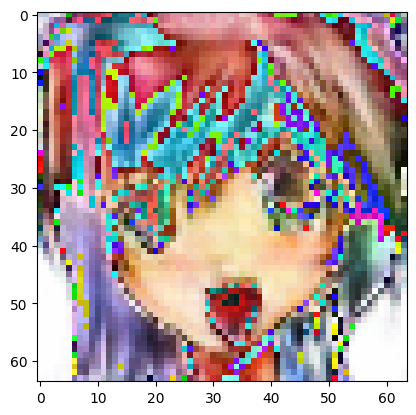

epoca numero 23


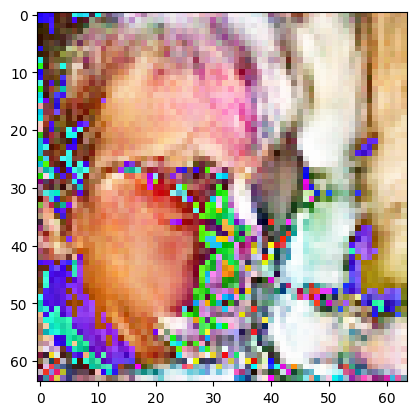

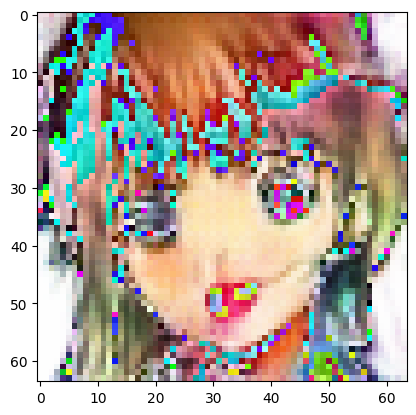

epoca numero 24


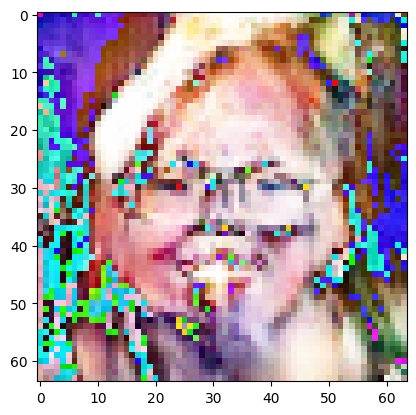

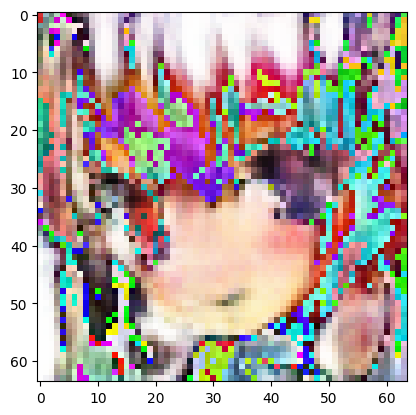

epoca numero 25


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/netGen204825.pt'

In [51]:
for epoca in range(epoche):
    print('epoca numero '+str(epoca))
    netGen.load_state_dict(torch.load('/kaggle/working/netGen2048'+str(epoca)+'.pt'))
    image0 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(0,1)[0])).reshape([1,102]).to(device))
    image1 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(1,1)[0])).reshape([1,102]).to(device))
    
    plt.imshow(tensorToPil(image0[0]))
    plt.show()
    plt.imshow(tensorToPil(image1[0]))
    plt.show()

In [ ]:
#for i in range(10):
#    print('ciao')
#    image = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),torch.Tensor([1,0]))).reshape([1,102]).to(device))
#    plt.imshow(tensorToPil(image[0]))
#    plt.show()

# **Training Encoder**

In [42]:
def trainEncoder(encoder,loss,optim,epoche,gen):
    for epoca in range(epoche):
        print('epoca numero '+str(epoca))
        for i in range(300):
            z = torch.Tensor()
            y = torch.Tensor()

            for j in range(32):
                z = torch.cat((z,(torch.normal(torch.zeros(100),torch.ones(100)).reshape([1,100]))))
                y = torch.cat((y,torch.Tensor([0,1]).reshape([1,2])))
            z = z.to(device)
            y = y.to(device)
            input = torch.cat((z,y),1).to(device)
            #print(input.size())
            x = gen(input)
            zEnc = encoder(x)
            #print(zEnc.size())
            #print(z.size())
            error = loss(zEnc,z.reshape([32,100]))
            error.backward(retain_graph=True)
            optim.step()
        print('epoca numero: ',epoca,'errore: ',error)
        torch.save(encoder.state_dict(), 'zEnc'+str(epoca)+'.pt')


In [27]:
#Scarichiamo i parametri
!gdown https://drive.google.com/file/d/1Tmopi6RIdzELsWySJD8df7Nx4Z-4fKAb/view?usp=drive_link --fuzzy
!gdown https://drive.google.com/file/d/1Ee61ARcEL-66OOxndVNmLj5B2rTUx7HK/view?usp=drive_link --fuzzy


Downloading...
From (original): https://drive.google.com/uc?id=1Tmopi6RIdzELsWySJD8df7Nx4Z-4fKAb
From (redirected): https://drive.google.com/uc?id=1Tmopi6RIdzELsWySJD8df7Nx4Z-4fKAb&confirm=t&uuid=b5be13cd-1fa3-4e21-9c4b-7ed5813b145d
To: /kaggle/working/netGen204813.pt
100%|███████████████████████████████████████| 76.4M/76.4M [00:00<00:00, 275MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ee61ARcEL-66OOxndVNmLj5B2rTUx7HK
From (redirected): https://drive.google.com/uc?id=1Ee61ARcEL-66OOxndVNmLj5B2rTUx7HK&confirm=t&uuid=2edda1fe-78a6-4099-8be2-6c44521854e0
To: /kaggle/working/netGen204815.pt
100%|███████████████████████████████████████| 76.4M/76.4M [00:00<00:00, 262MB/s]


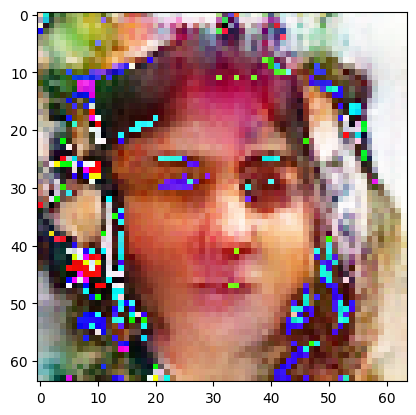

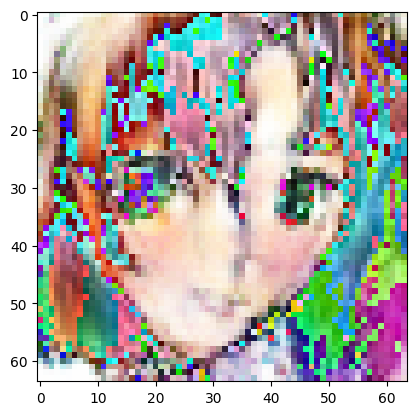

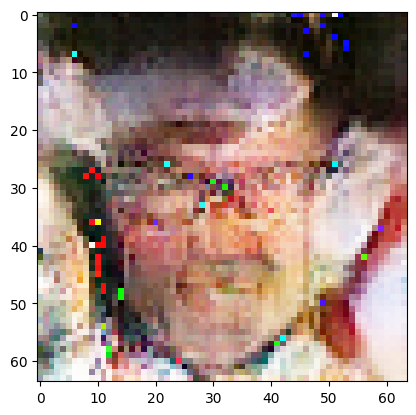

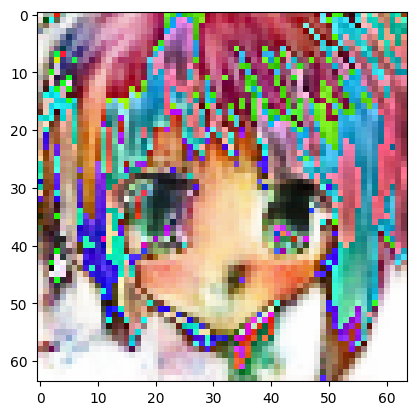

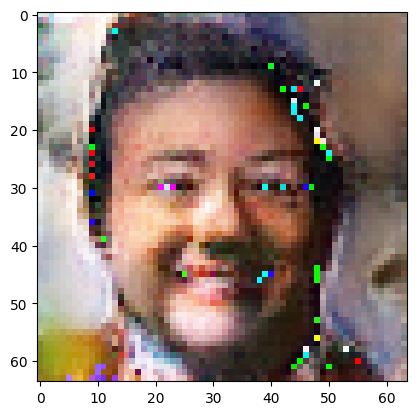

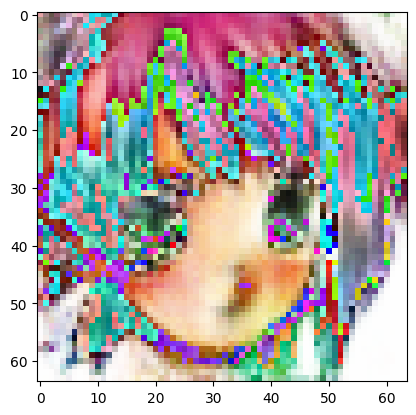

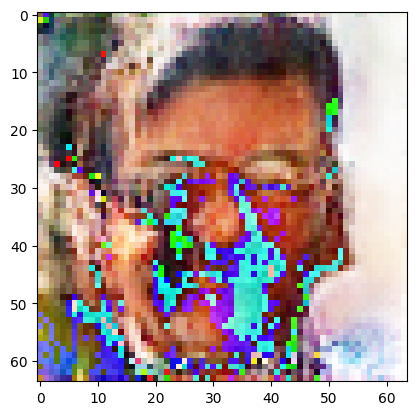

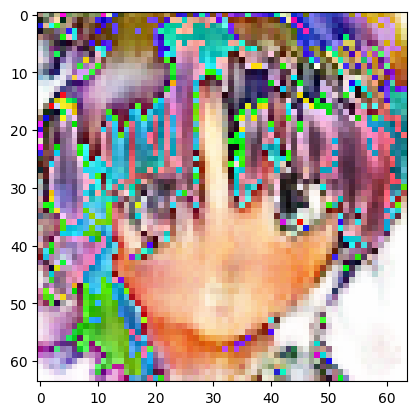

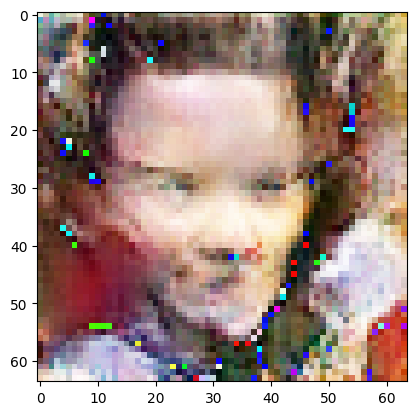

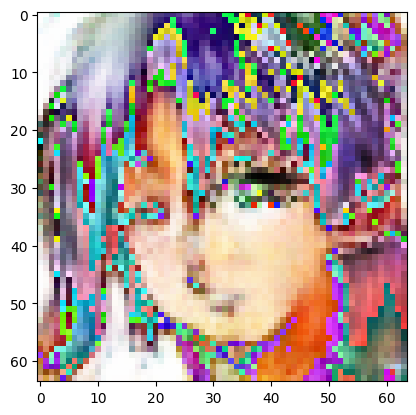

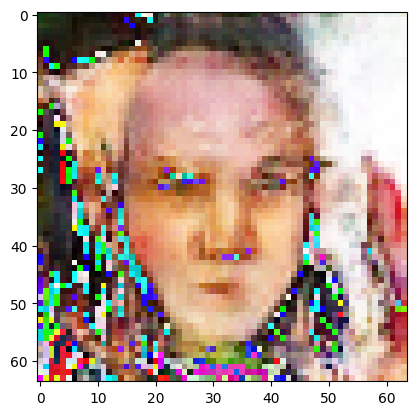

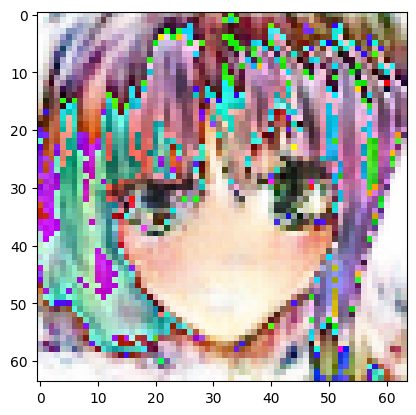

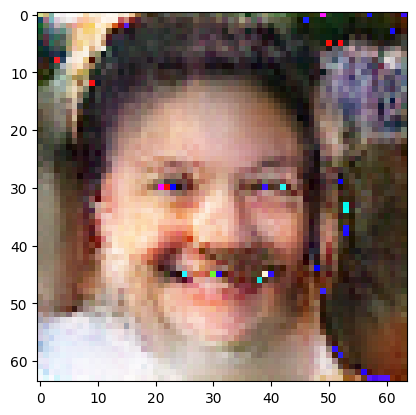

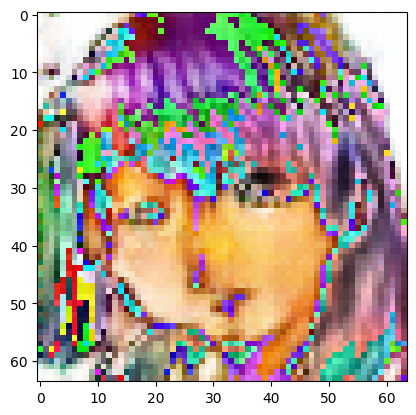

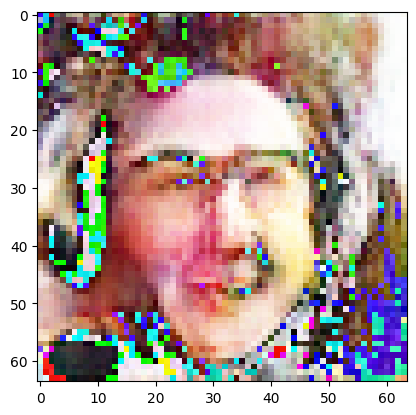

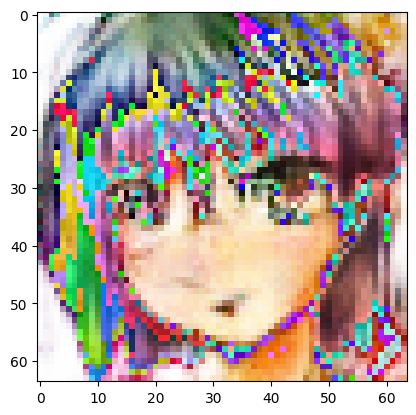

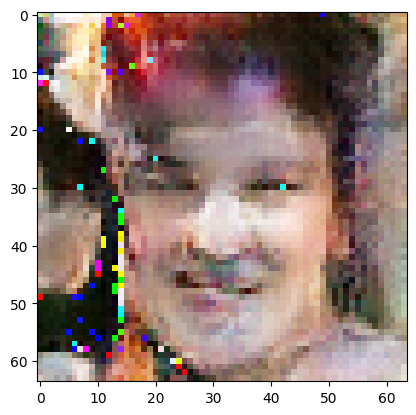

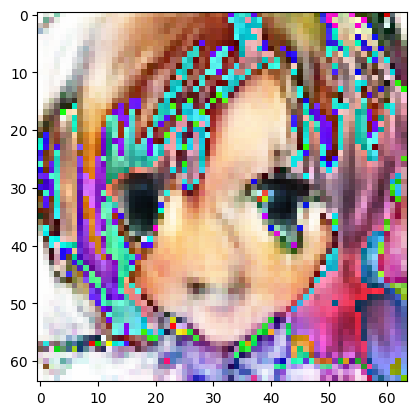

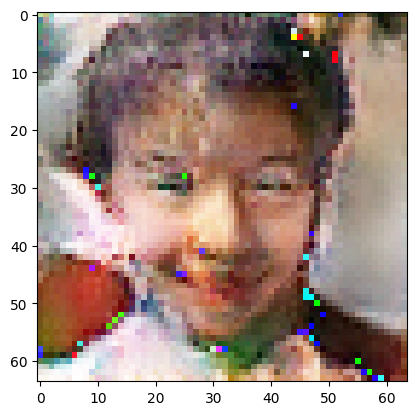

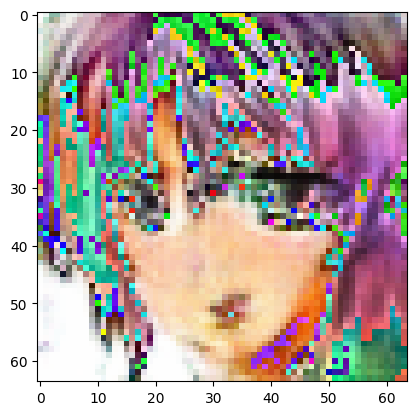

In [28]:
#Caricare i paremetri della rete generariva
if device=='cpu':
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204813.pt',map_location=torch.device('cpu')))
else:
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204813.pt'))


for i in range(10):
    image0 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(0,1)[0])).reshape([1,102]).to(device))
    image1 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(1,1)[0])).reshape([1,102]).to(device))
    plt.imshow(tensorToPil(image0[0]))
    plt.show()
    plt.imshow(tensorToPil(image1[0]))
    plt.show()

#plt.show()

#Creare il Dataset
#encTrainDataset = encoderTrainDataset(10000,netGen)
#Creare il Dataloader
#encTrainDataloader = torch.utils.data.DataLoader(encTrainDataset, batch_size=batchSize,shuffle=True)

#Allenare la rete y
#trainEncoder(netEncZ,lossEncoder,optEncZ,epoche,netGen)

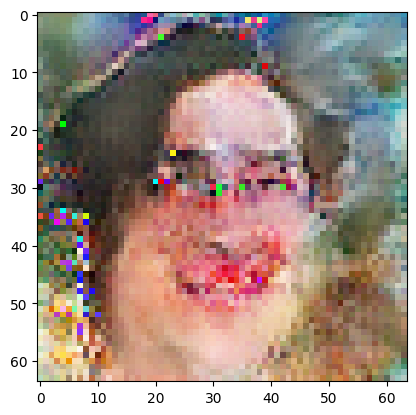

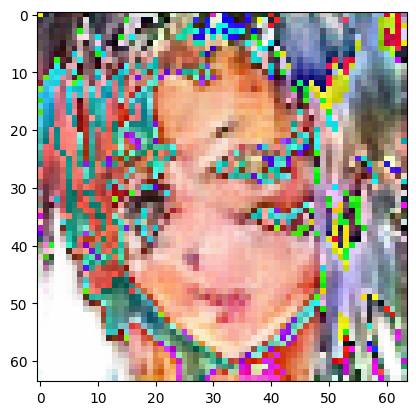

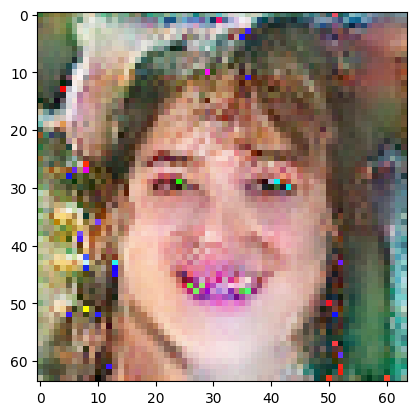

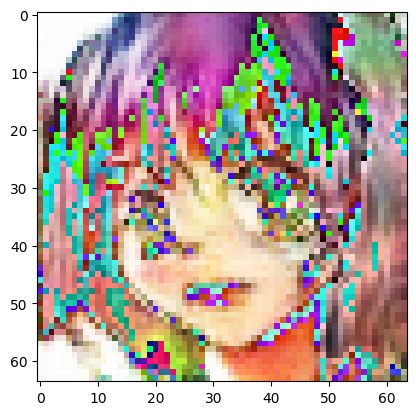

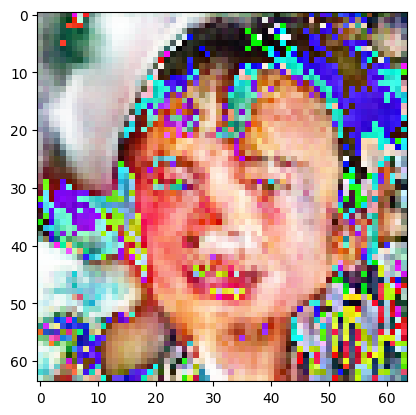

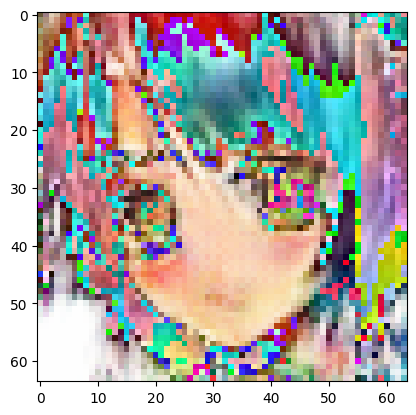

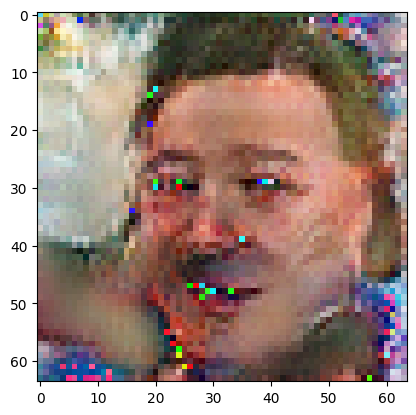

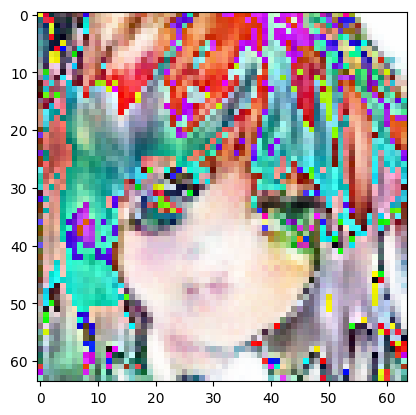

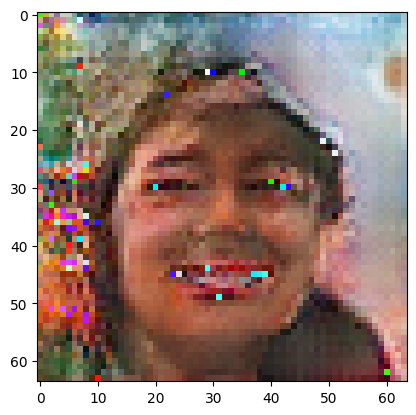

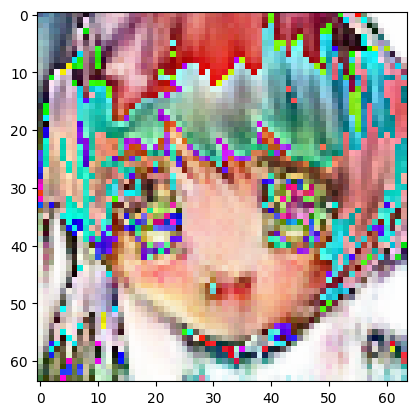

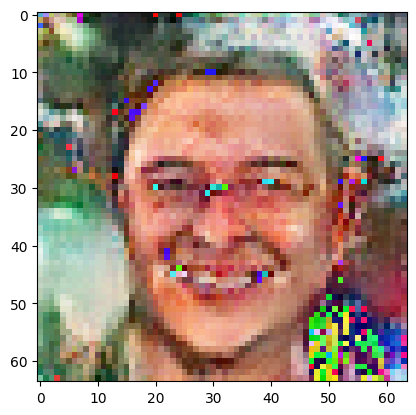

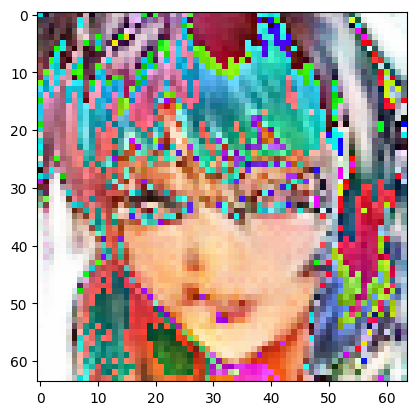

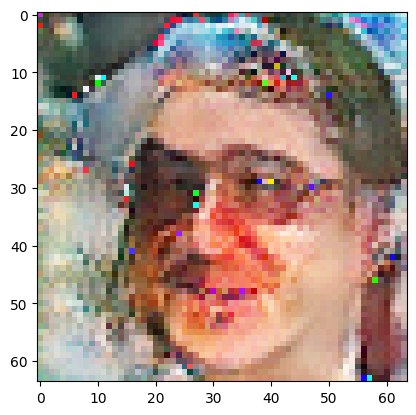

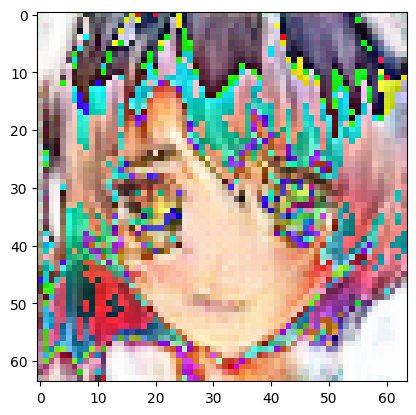

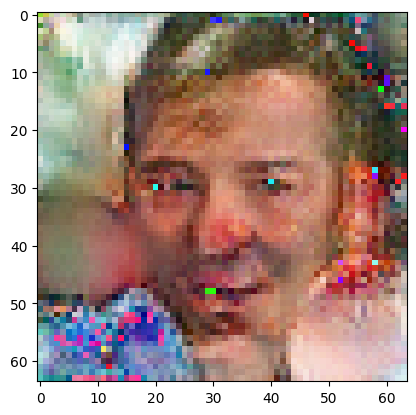

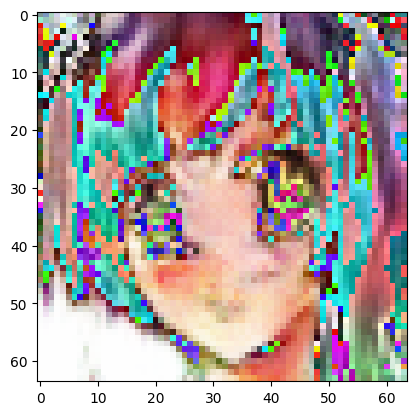

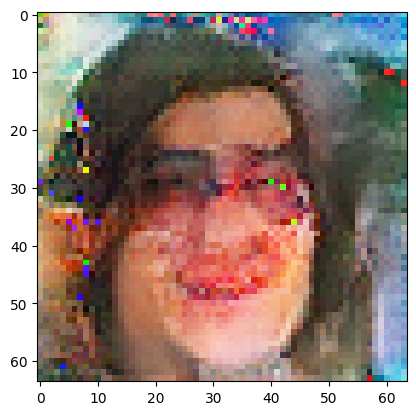

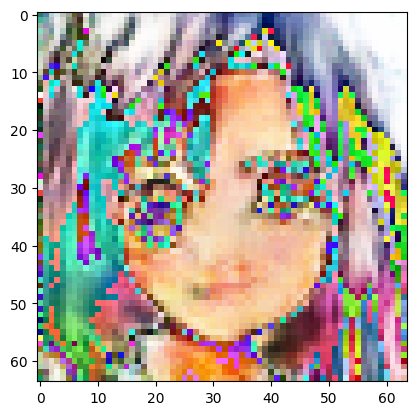

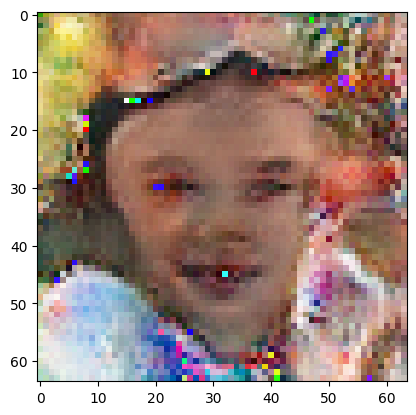

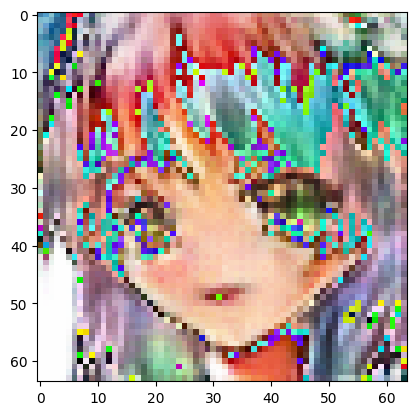

In [29]:
#Caricare i paremetri della rete generariva
if device=='cpu':
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204815.pt',map_location=torch.device('cpu')))
else:
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204815.pt'))


for i in range(10):
    image0 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(0,1)[0])).reshape([1,102]).to(device))
    image1 = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(1,1)[0])).reshape([1,102]).to(device))
    plt.imshow(tensorToPil(image0[0]))
    plt.show()
    plt.imshow(tensorToPil(image1[0]))
    plt.show()

In [43]:
trainEncoder(netEncZ,lossEncoder,optEncZ,epoche,netGen)

epoca numero 0
epoca numero:  0 errore:  tensor(0.7286, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 1
epoca numero:  1 errore:  tensor(0.6998, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 2
epoca numero:  2 errore:  tensor(0.7367, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 3
epoca numero:  3 errore:  tensor(0.6906, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 4
epoca numero:  4 errore:  tensor(0.6956, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 5
epoca numero:  5 errore:  tensor(0.7201, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 6
epoca numero:  6 errore:  tensor(0.6878, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 7
epoca numero:  7 errore:  tensor(0.7051, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 8
epoca numero:  8 errore:  tensor(0.6601, device='cuda:0', grad_fn=<MseLossBackward0>)
epoca numero 9
epoca numero:  9 errore:  tensor(0.6717, device='cuda:0', grad_fn=<MseLossBa

# **Test**

In [29]:
#Scarichiamo i parametri delle reti
!gdown https://drive.google.com/file/d/1Xil8dZ0UluHdAB8EAdOWT7bN_oy7Ox3T/view?usp=drive_link --fuzzy
!gdown https://drive.google.com/file/d/1ptMF6Qby0OLAFhqyea7BEmQ5KAETM0IZ/view?usp=drive_link --fuzzy
!gdown https://drive.google.com/file/d/1HSGsFyP0CSdjF072jRkPVyg_t6BziTXU/view?usp=drive_link --fuzzy
!gdown https://drive.google.com/file/d/1RplPzf_fN7VHXNT-_tnF1aYkUo7bWTO1/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1Xil8dZ0UluHdAB8EAdOWT7bN_oy7Ox3T
From (redirected): https://drive.google.com/uc?id=1Xil8dZ0UluHdAB8EAdOWT7bN_oy7Ox3T&confirm=t&uuid=c3c0dfd1-f599-4db8-ac60-3a97a84b01f5
To: /kaggle/working/netGen204815.pt
100%|███████████████████████████████████████| 76.4M/76.4M [00:00<00:00, 171MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ptMF6Qby0OLAFhqyea7BEmQ5KAETM0IZ
From (redirected): https://drive.google.com/uc?id=1ptMF6Qby0OLAFhqyea7BEmQ5KAETM0IZ&confirm=t&uuid=c90c1177-0198-44d6-9dc9-8d7e7cfcf8e4
To: /kaggle/working/netGen204813.pt
100%|██████████████████████████████████████| 76.4M/76.4M [00:01<00:00, 39.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HSGsFyP0CSdjF072jRkPVyg_t6BziTXU
To: /kaggle/working/zEnc23.pt
100%|███████████████████████████████████████| 10.2M/10.2M [00:00<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RplPzf_fN7VHXNT-_tnF1aYkUo7bWTO1
To: /kaggle/worki

In [74]:
if device=='cpu':
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204815.pt',map_location=torch.device('cpu')))
    netEncZ.load_state_dict(torch.load('/kaggle/working/zEnc24.pt',map_location=torch.device('cpu')))
else:
    netGen.load_state_dict(torch.load('/kaggle/working/netGen204815.pt'))
    netEncZ.load_state_dict(torch.load('/kaggle/working/zEnc24.pt'))


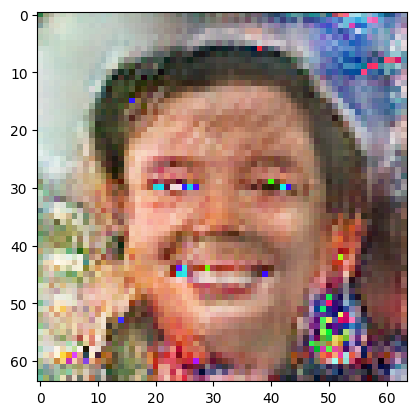

In [75]:
#Prendere batch di immagini
images = torch.Tensor().to(device)
for i in range(32):
    image = netGen(torch.cat((torch.normal(torch.zeros(100),torch.ones(100)),generatorLabel(0,1)[0])).reshape([1,102]).to(device))
    images =  torch.cat((images,image))
#Visualizzarle
plt.imshow(tensorToPil(images[0]))   



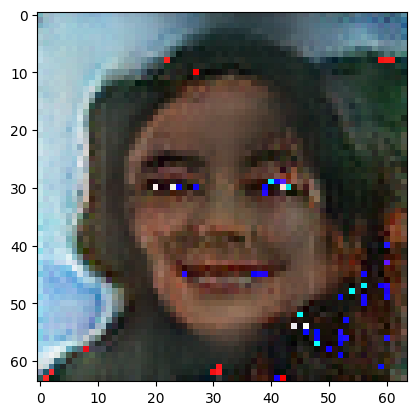

In [76]:
#Trovarle nello spazio latente
zS = netEncZ(images)
#Rigenerarle
yU = generatorLabel(0,32).to(device)
yA = generatorLabel(0,32).to(device)
imagesRicostruite = netGen(torch.cat((zS,yU),1).to(device))
plt.imshow(tensorToPil(imagesRicostruite[0]))    

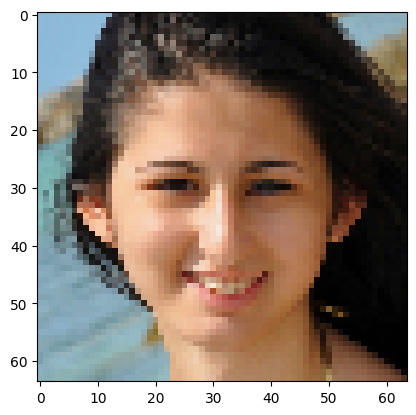

In [103]:
iteratoreHuman = iter(humanDataloader)
images, yHuman = next(iteratoreHuman)
plt.imshow(tensorToPil(images[0])) 

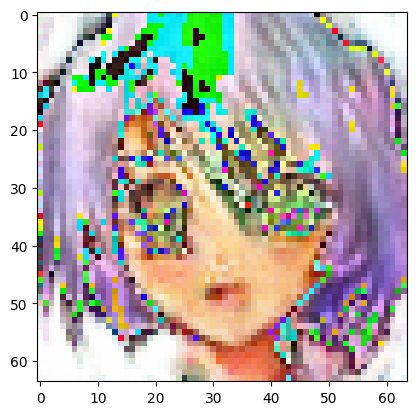

In [105]:
#Trovarle nello spazio latente
zS = netEncZ(images)
# Rigenerarle
# Inserire yU o yA a seconda che si voglia ricostruire le immagini in versione 
# normale o in versione anime
yU = generatorLabel(0,32).to(device)
yA = generatorLabel(1,32).to(device)
imagesRicostruite = netGen(torch.cat((zS,yA),1).to(device))
plt.imshow(tensorToPil(imagesRicostruite[0]))    